# Wstęp
Laboratorium 5 stanowi wprowadzenie w tematykę sieci konwolucyjnych. Sieci te wykorzystują, jak sama nazwa wskazuje, operację konwolucji (splotu) co pozwala na uwzględnienie informacji o lokalnym sąsiedztwie przestrzennym w przetwarzanych danych. W przypadku obrazów, jest to sąsiedztwo pikseli w dwuwymiarowej przestrzeni obrazu.

# Cel  ćwiczenia

Celem ćwiczenia jest zapoznianie z:

*   operacją konwolucji 2D i jej implementacją w torchu
*   warstwami konwolucyjnymi i ich parametrami
*   operacjami poolingu
*   prostymi sieciami konwolucyjnymi w klasyfikacji obrazu

# Konwolucja 2D

Najpierw wprowadzimy operację konwolucji. Konwolucja 2D przyjmuje na wejściu tensory o kształcie `(B,C,H,W)` - batch, channel, width, height. Kanały nazywamy też *mapami cech*, jako że w warstwach innych niż wejściowa są to w dalszym ciągu dwuwymiarowe "obrazki", ale odpowiadające już nie wprost kanałom RGB, ale pewnym cechom wydobywanym z mapy cech na wejściu przez uczące się filtry. 

Tensor filtrów ma wymiary `(I,O,H,W)` - liczba kanałów warstwy wejściowej, liczba kanałów warstwy wyjściowej, wysokość i szerokość filtra. Możemy pomyśleć o tym przez analogię z warstwą w pełni połączoną: tam, element tensora wag `weights[i,j]` był jedną liczbą i odpowiadał połączeniu i-tego wejścia do j-tego wyjścia. W konwolucji, `weights[i,j]`  będzie odpowiadać połączeniu i-tej mapy cech do j-tej mapy cech, będzie jednak całą macierzą, ponieważ dla każdego połączenia we-wy map cech uczymy dwuwymiarowego filtra.

Dla przykładu, zaimplementujmy filtr rozmywający obraz RGB - każdy kanał z osobna. Filtr rozmywający jeden kanał definiuje `filter`, a ponieważ chcemy uzyskać połączenie tylko kanałów wejściowych do wyjściowych: R do R, G do G, B do B, a ponieważ dla każdego z tych połączeń filtr będzie taki sam, możemy po prostu wymnożyć go przez tensor `(3,3,1,1)`, utworzony z macierzy jednostkowej. W torchu taką macierz zwraca metoda `eye`.

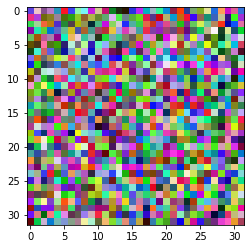

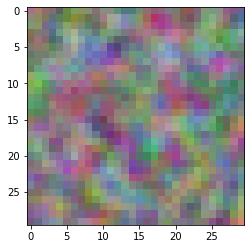

In [ ]:
import torch
from matplotlib import pyplot as plt

tensor = torch.rand((1,3,32,32))

channel_connections = torch.eye(3)

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

blur = channel_connections.view(3,3,1,1)*filter

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

blurred = torch.nn.functional.conv2d(tensor,blur)

plt.imshow(blurred[0].permute(1,2,0))
plt.show()


# Zadanie 1

Zdefiniuj tensor 3x3x3x3 `rg_blur_to_b`.

Zakładając że mamy do czynienia z obrazem RGB, konwolucja na wyjściu zwracać ma obraz RGB, gdzie 

* w kanale B zwracamy uśrednienie rozmytych (analogiczne jak wyżej) kanałów R, G obrazka wejściowego
* kanały R i G na wyjściu są zerami


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


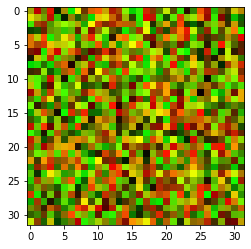

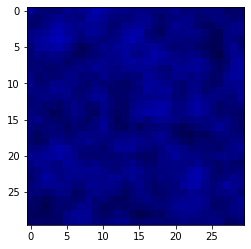

In [ ]:
tensor = torch.rand((10,3,32,32))
tensor[:,2] = -7

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

rg_blur_to_b = # stwórz tensor
blurred = torch.nn.functional.conv2d(tensor,rg_blur_to_b)

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

plt.imshow(blurred[0].permute(1,2,0))
plt.show()



# Warstwa konwolucyjna

W sieci konwolucyjnej będziemy wykorzystywać operację konwolucji tak jak opisane powyżej, w której uczone są tensor filtrów i bias dodawany do tensora na wyjściu. Warstwę z uczonymi parametrami definiuje klasa:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Pokrótce wyjaśnijmy parametry tej klasy na przykładzie filtra 2x2.

Poniższy obrazek reprezentuje lewy, górny róg mapy cech:

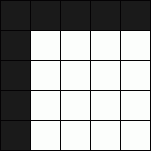

Na czerwono zaznaczymy pierwszy krok filtra przechodzącego po obrazie, na niebiesko drugi. Kolor fioletowy oznaczać będzie, że pola obejmowane przez filtry się pokrywają. Oznaczone pola przekładają się na dwa pierwsze piksele w wyjściowej mapie cech. Filtr 2x2 przy domyślnych parametrach będzie przechodził po obrazie następująco:

--------- Wejście ---------------------  Wyjście ----------

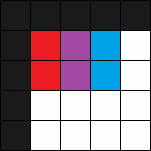
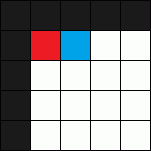


W kodzie deklarujemy w pierwszych trzech argumentach konstruktora `torch.nn.Conv2d`: liczbę kanałów wejściowych, liczbę kanałów wyjściowych, rozmiar filtra. Przy okazji, torchowa konwencja - aby podać rozmiar okna 2d możemy użyć jako argumentu zarówno krotki (x,y) jak i jednej liczby całkowitej, definiującej okno kwadratowe (x,x).

In [ ]:
data_batch = torch.zeros(10,16,32,32)

#deklaracja warstwy: 16 kanałów wejściowych, 32 wyjściowych, filtr 2x2
conv_layer = torch.nn.Conv2d(16,32,2) 

conv_layer(data_batch).shape

torch.Size([10, 16, 31, 31])

Jak widać, w wymiarach szerokości i wysokości, mapy cech zmniejszają się o 1.

Parametr `padding` pozwala na dodanie dodatkowych pikseli na krawędzi obrazka. Używany jest, aby zachować stałą szerokość i wysokość mapy cech po konwolucji. Dla `padding=1` pola obejmowane przez filtr będą wyglądać tak: 

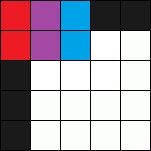

In [ ]:
data_batch = torch.zeros(10,16,32,32)

conv_layer = torch.nn.Conv2d(16,16,2,padding=1) 
print(conv_layer(data_batch).shape)

conv_layer = torch.nn.Conv2d(16,16,3,padding=1) 
print(conv_layer(data_batch).shape)

torch.Size([10, 16, 33, 33])
torch.Size([10, 16, 32, 32])


Zauważ, że ze względu na symetryczny padding (dodawanie pikseli po obu stronach obrazu wejściowego) operacja zachowuje wysokość i szerokość tylko dla filtra o nieparzystym rozmiarze.

Parametr `stride` to krok filtra. Używany jest aby zredukować wymiary szerokości i wysokości pomiędzy kolejnymi warstwami konwolucyjnymi. `stride=2` daje nam downsampling do dwukrotnie mniejszej rozdzielczości, z wykorzystaniem uczącej się warstwy która może jednocześnie zmienić liczbę kanałów:

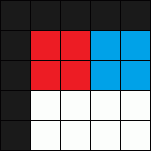


In [ ]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,stride=2) 

conv_layer(data_batch).shape

torch.Size([10, 16, 16, 16])

Parametr `dilation` określa rozstaw filtra. Pozwala to obejmować filtrem piksele odległe od siebie o pewną stałą wartość. Szczególnie istotnym wykorzystaniem tego parametru jest użycie sekwencji warstw, w których kolejne wartości `dilation` to kolejne potęgi 2 - efektywnie skalując rozmiar pola obejmowanego przez całą architekturę wykładniczo z głębokością. Dla `dilation=2`:

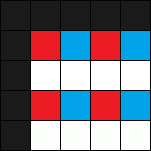

In [ ]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,dilation=2) 

conv_layer(data_batch).shape

torch.Size([10, 16, 30, 30])

#Pooling

Zanim z warstw zbudujemy sieć, warto jeszcze wprowadzić operacje: poolingu i spłaszczania.

In [ ]:
pool_layer =  torch.nn.MaxPool2d(2) #okno o stałym rozmiarze 2x2
adaptive_pool_layer = torch.nn.AdaptiveAvgPool2d((2,4)) #pooling adaptacyny
flatten_layer = torch.nn.Flatten()

data_batch = torch.zeros(10,3,128,128)
pool_layer(data_batch).shape, adaptive_pool_layer(data_batch).shape, flatten_layer(data_batch).shape

(torch.Size([10, 3, 64, 64]),
 torch.Size([10, 3, 2, 4]),
 torch.Size([10, 49152]))

Dwa standardowe typy poolingu to Max i Average pooling - zwracające odpowiednio maximum lub średnią z okna pooling. 

Pooling o stałym rozmiarze okna pozwala nam na downsampling w wymiarach szerokości i wysokości bez potrzeby dodawania uczącej się warstwy. Przykładowo, okno 2x2 da nam redukcję szerokości i wysokości o dwa razy.

Pooling o adaptacyjnym rozmiarze okna pozwala na sprowadzenie wyniku konwolucji do stałego, zadanego rozmiaru wysokość/szerokość, co jest szczególnie przydatne jeśli chcemy przetwarzać obrazy o różnych rozmiarach. Zwykle wykorzystuje się go tylko w jednym miejscu, przed spłaszczeniem i ostatnią warstwą w pełni połączoną. Adaptacyjna warstwa poolingu z parametrem 2 bedzie redukować rozmiar w wymiarach wysokość, szerokośc do 2 na 2 - samodzielnie wyliczając dla każdego wejścia rozmiar okna potrzebny, żeby takie wyjście uzyskać.

Spłaszczanie zaś, jak sama nazwa wskazuje spłaszcza kształt tensora z (B, C, H, W) do (B, C\*H\*W)





Aby przejść do budowania i uczenia sieci konwolucyjnych, wczytamy zbiór CIFAR10. Zdefiniujemy też funkcje wykorzystane już na poprzednich laboratoriach:

In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )       


Extracting cifar_root/cifar-10-python.tar.gz to cifar_root
Files already downloaded and verified


Zdefiniujmy teraz prostą sieć konwolucyjną.

# Zadanie 2

Uzupełnij kod klasy `SimpleCNN` tak, aby warstwy konwolucyjne nie zmieniały szerokości i wysokości mapy cech na wyjściu oraz aby wyjście w postaci tensora miało kształt zgodny z pożądanym `(batch_size, labels)`. Użyj rozmiaru filtra 3x3. 

Zauważ, że o ile warstwy konwolucyjne nie muszą znać rozmiaru obrazu, o tyle spłaszczenie obrazu i podanie do warstwy w pełni połączonej wymusza na nas zdefiniowanie tego rozmiaru z góry. Sieć zbudowana w ten sposób przetwarzać będzie tylko obrazy o stałej szerokości i wysokości. Na potrzeby zadania, sieć ma być dostosowana do zbioru CIFAR: przyjmować obrazy RGB, 32x32 na wejściu i zwracać 10-elementowy wektor na wyjściu.

In [ ]:
class SimpleCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1", #  tu zdefiniuj warstwę konwolucyjną
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool", torch.nn.MaxPool2d(2))
    self.model.add_module("conv_2"  # tu zdefiniuj warstwę konwolucyjną
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear" # tu zdefiniuj warstwę w pełni połączoną
  
  def forward(self, x):
    return self.model(x)

Zweryfikuj, że sieć zwraca wlaściwy wymiar wyjścia i zmierz czas przetwarzania konwolucji na CPU i GPU

In [ ]:
cnn_model = SimpleCNN(16, 10)
out = cnn_model(torch.zeros(128,3,32,32))
assert out.shape==(128,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())


100 loops, best of 5: 13.7 ms per loop
The slowest run took 18.83 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1 ms per loop


Sprawdźmy, że jesteśmy w stanie uczyć tę sieć:

In [ ]:
optimizer = optim.Adam(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 5, True)

Epoch 0: train loss = 0.038 (acc: 0.589), validation loss = 0.039 (acc: 0.564)
Epoch 1: train loss = 0.037 (acc: 0.604), validation loss = 0.039 (acc: 0.574)
Epoch 2: train loss = 0.035 (acc: 0.622), validation loss = 0.038 (acc: 0.581)
Epoch 3: train loss = 0.034 (acc: 0.626), validation loss = 0.038 (acc: 0.587)
Epoch 4: train loss = 0.035 (acc: 0.620), validation loss = 0.039 (acc: 0.572)


# Zadanie 3

Zdefiniuj klasę `CNN`, sieć o strukturze

*   warstwa wejściowa in_conv o rozmiarze filtra 1x1 (transformacja liczby kanałów)
*   naprzemiennie - konwolucja, downsampling x2, konwolucja...
*   spłaszczenie wyniku do wektora
*   warstwa w pełni połączona

Klasa powinna być parametryzowalna tak, aby

*   umożliwić wybór rozmiaru filtra w warstwach konwolucji oprócz in_conv
*   umożliwić wybór zarówno liczby warstw, jak i liczby kanałów w poszczególnych warstwach konwolucyjnych
*   umożliwić wybór między downsamplingiem z użyciem poolingu a użyciem  warstwy konwolucyjnej




In [ ]:
class CNN(torch.nn.Module):
  def __init__(self, # napisz konstruktor z parametrami

  def forward(self,x):
    # napisz funkcję forward

Zweryfikuj działanie implementacji:

In [ ]:
dummy_data = torch.zeros(37,3,32,32)

cnn_model = CNN( # utwórz CNN z: 15 etykietami wyjściowymi, filtrem 5x5, 3 warstwy conv z liczbą kanałów: 16,32,64, downsampling warstwą konwolucyjną 
assert cnn_model(dummy_data).shape == (37,15)

cnn_model = CNN( # utwórz CNN: 10 etykiet wyjściowych, filtr 3x3, 4 warstwy conv z liczbą kanałów: 8,16,32,64, downsampling warstwą poolingu
assert cnn_model(dummy_data).shape == (37,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())

10 loops, best of 5: 43.7 ms per loop
100 loops, best of 5: 3.04 ms per loop


# Zadanie 4

Wykorzystaj zdefiniowaną klasę, aby przeprowadzić porównania:

1.   Uczenie z filtrem 3x3 a 5x5
2.   Uczenie z Max Pooling a warstwą konwolucją do downsamplingu
3.   Uczenie z trzema warstwami o rozmiarach 16,32,64, a uczenie z trzema warstwami o rozmiarach 32,32,32

Porównaj w kontekście metryki F-score, wyrysuj krzywe uczenia. Możesz tu korzystać z kodu napisanego na poprzednich laboratoriach.


In [ ]:
# użyj klasy CNN aby wykonać eksperymenty